In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import ta
from arch import arch_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import norm


c:\Users\user\anaconda3\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


 Fetch Data

In [3]:
ticker = 'AAPL'  # Microsoft Corporation
data = yf.download(ticker, start='2023-01-01', end='2023-11-01')
print(data.head())

    


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AAPL']: ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out."))


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


Initial Data Cleaning

In [4]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values
data.dropna(inplace=True)


Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64


In [5]:
# Data Preprocessing
data['Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(1 + data['Returns'])
data.dropna(inplace=True)

In [6]:
# Calculate the mean and standard deviation of log returns
mu = data['Log_Returns'].mean()
sigma = data['Log_Returns'].std()


In [7]:
# Monte Carlo Simulation Setup
simulation_df = pd.DataFrame()


In [8]:
# Number of trading days and simulations
num_days = 500
num_simulations = 10000

last_price = data['Close'][-1]

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# Generate simulated price paths
for x in range(num_simulations):
    count = 0
    
    prices = [last_price]
    for y in range(num_days):
        price = prices[count] * np.exp(mu + sigma * norm.ppf(np.random.rand()))
        prices.append(price)
        count += 1
    
    simulation_df[x] = prices

C:\Users\user\AppData\Local\Temp\ipykernel_16116\1031835277.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_df[x] = prices
C:\Users\user\AppData\Local\Temp\ipykernel_16116\1031835277.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_df[x] = prices
C:\Users\user\AppData\Local\Temp\ipykernel_16116\1031835277.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

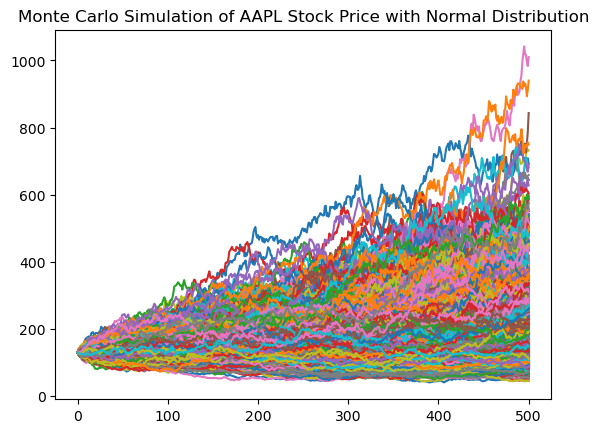

In [ ]:
# Plotting the first 10 simulations
fig = plt.figure()
plt.plot(simulation_df.iloc[:, :100000])
plt.title('Monte Carlo Simulation of AAPL Stock Price with Normal Distribution')
plt.show()

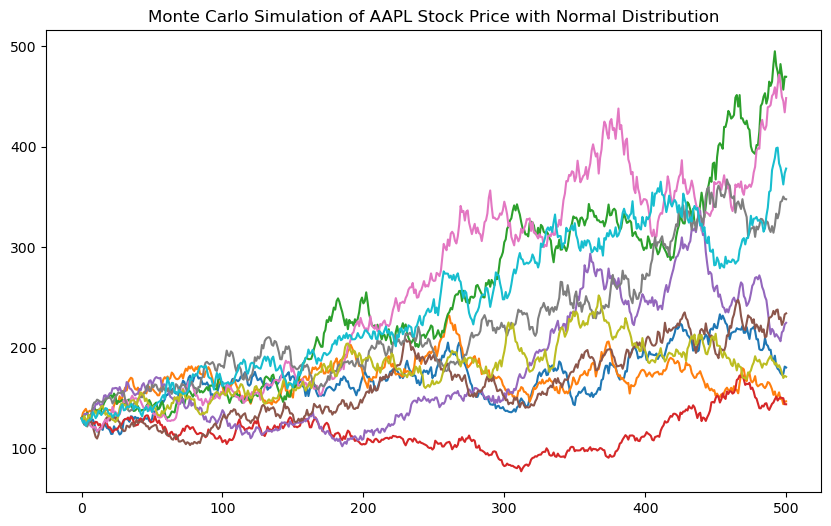

In [ ]:
# Plotting the first 10 simulations
fig = plt.figure(figsize=(10, 6))
plt.plot(simulation_df.iloc[:, :10])
plt.title('Monte Carlo Simulation of AAPL Stock Price with Normal Distribution')
plt.show()

In [ ]:
# For logistic regression, we use actual data
data['Target'] = (data['Returns'] > 0).astype(int)

In [ ]:
# Feature selection
X = data[['Close', 'Log_Returns']][:-1]
y = data['Target'][1:]


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Logistic Regression Model
model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=100)
model.fit(X_train, y_train)



LogisticRegression(solver='liblinear')

 la courbe d'apprentissage pour visualiser comment les performances du modèle évoluent avec la taille de l'ensemble d'entraînement.

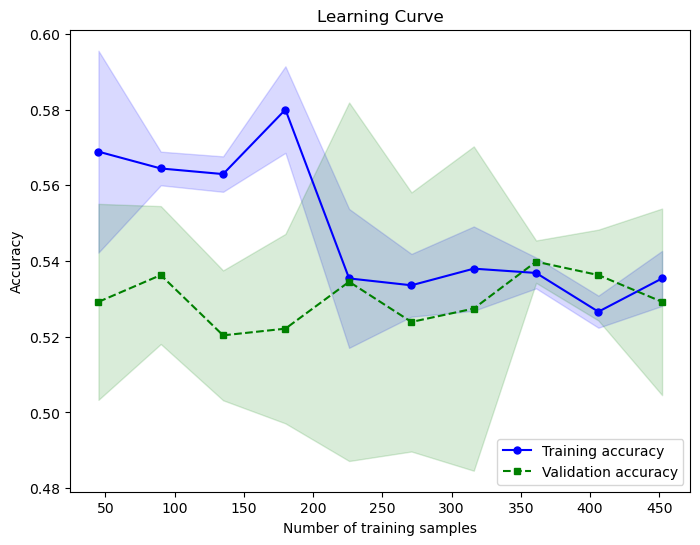

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
predictions = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
pearson_corr = np.corrcoef(y_test, predictions)[0, 1]
print("Mean_Squared_Error:", mse)
print("R-squared:", r2)



Mean_Squared_Error: 0.4708994708994709
R-squared: -0.8989613908331449


In [ ]:
predictions = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.18      0.30       103
           1       0.49      0.94      0.65        86

    accuracy                           0.53       189
   macro avg       0.64      0.56      0.47       189
weighted avg       0.65      0.53      0.46       189

Confusion Matrix:
[[19 84]
 [ 5 81]]


In [ ]:
#data processi with gbm
data['Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(1 + data['Returns'])

# Adding technical indicators
data['MACD'] = ta.trend.MACD(data['Close']).macd_diff()
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
data['Bollinger_High'], data['Bollinger_Low'] = ta.volatility.bollinger_hband(data['Close']), ta.volatility.bollinger_lband(data['Close'])

data.dropna(inplace=True)


Logistic Regression Replacement with GBM and Hyperparameter Tuning

In [ ]:
# Target variable
data['Target'] = (data['Returns'] > 0).astype(int)

# Features selection including technical indicators
X = data[['Log_Returns', 'MACD', 'RSI', 'Bollinger_High', 'Bollinger_Low']][:-1]
y = data['Target'][1:]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

# Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    
}
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Best model and predictions
best_gbm = grid_search.best_estimator_
predictions = best_gbm.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

NameError: name 'data' is not defined

In [ ]:
# Fit GARCH Model
garch_model = arch_model(data['Returns']*100, vol='Garch', p=1, q=1, mean='zero').fit(disp='off')
forecast = garch_model.forecast(horizon=1)
next_day_volatility = forecast.variance.iloc[-1]**0.5 / 100  # Scale adjustment
print(f"Forecasted next day volatility: {next_day_volatility.values[0]}")


Forecasted next day volatility: 0.0209307512363749
